#**Financial markets project**
Course of Deep learning and artificial intelligence, 2021, La Sapienza

Author: Lorenzo Di Fruscia

##**Import dependencies**

In [195]:
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import math
import matplotlib.pyplot as plt


In [196]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

##**Dataset preparation**

In [197]:
dataset = yf.download("GOOG", start="2011-01-01", end="2021-01-01") # default is daily stock data

[*********************100%***********************]  1 of 1 completed


In [198]:
labels = list(dataset.columns) # ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
print(dataset.head(), "\n", dataset.count())

                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2011-01-03  297.126312  301.664276  297.126312  301.046600  301.046600  4748131
2011-01-04  301.679230  301.958191  298.939514  299.935760  299.935760  3662677
2011-01-05  298.914581  304.025452  298.904633  303.397797  303.397797  5083583
2011-01-06  304.199799  308.060303  303.885956  305.604523  305.604523  4131026
2011-01-07  306.805023  307.970642  303.925812  307.069031  307.069031  4218152 
 Open         2517
High         2517
Low          2517
Close        2517
Adj Close    2517
Volume       2517
dtype: int64


##**Preprocessing pt.1**

In [199]:
data = dataset.loc[:, ['Open'] ]

naive_data = data.shift(1) # naive_data will be used for naive forecast with "persistence algorithm"
naive_data = naive_data.iloc[1:]

print(data, "\n", naive_data) # different lengths!

                   Open
Date                   
2011-01-03   297.126312
2011-01-04   301.679230
2011-01-05   298.914581
2011-01-06   304.199799
2011-01-07   306.805023
...                 ...
2020-12-24  1735.000000
2020-12-28  1751.635010
2020-12-29  1787.790039
2020-12-30  1762.010010
2020-12-31  1735.420044

[2517 rows x 1 columns] 
                    Open
Date                   
2011-01-04   297.126312
2011-01-05   301.679230
2011-01-06   298.914581
2011-01-07   304.199799
2011-01-10   306.805023
...                 ...
2020-12-24  1728.109985
2020-12-28  1735.000000
2020-12-29  1751.635010
2020-12-30  1787.790039
2020-12-31  1762.010010

[2516 rows x 1 columns]


In [200]:
data = torch.tensor(data.values).squeeze(-1)
naive_data = torch.tensor(naive_data.values).squeeze(-1)

###**Plot of 'open prices' dataset**

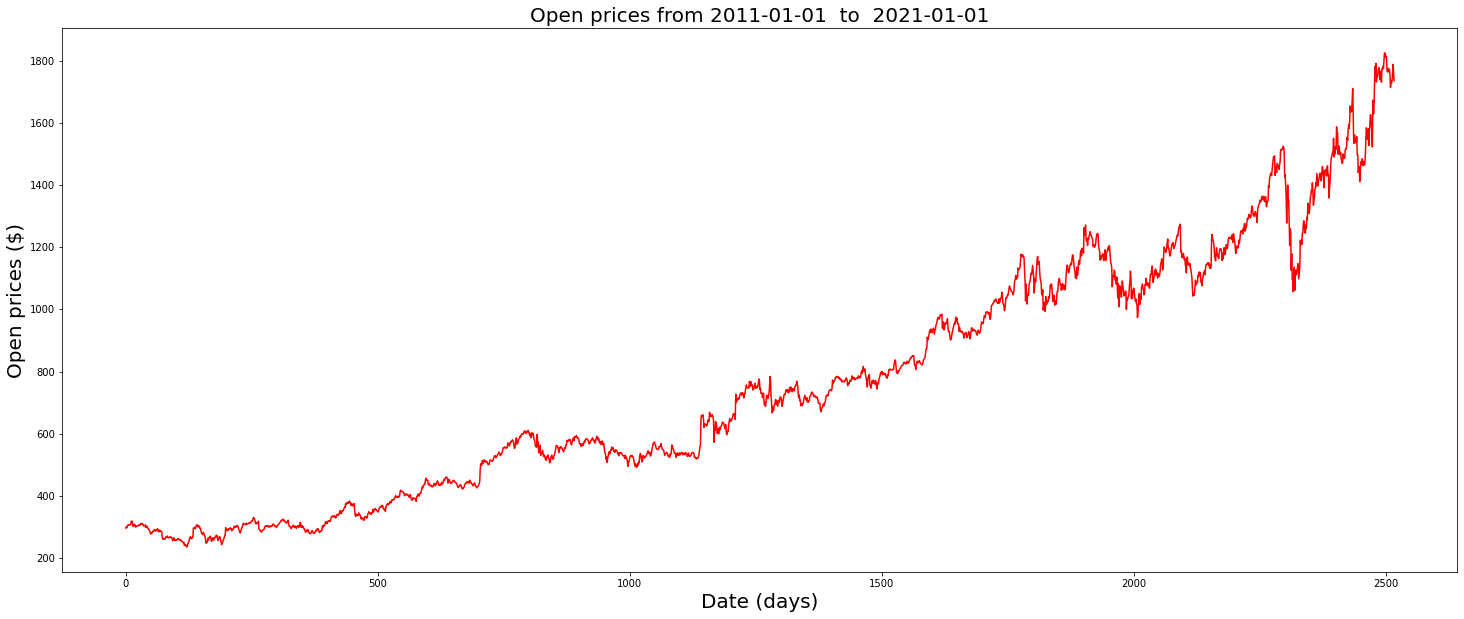

In [201]:
# Plot of open prices dataset

plt.figure(figsize=(25,10))
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Open prices ($)", fontsize = 20)
plt.title("Open prices from 2011-01-01  to  2021-01-01", fontsize = 20)

plt.plot(range(len(data)), data, color="red") 

###**Differencing the data**

In [202]:
# Calculating daily returns. Differencing data to ease training, now the process is stationary.

returns = torch.diff(data)
returns = (returns/ data[:-1]).float()

print("Dataset size: ", returns.shape)

Dataset size:  torch.Size([2516])


###**Plot of 'open prices' returns dataset**

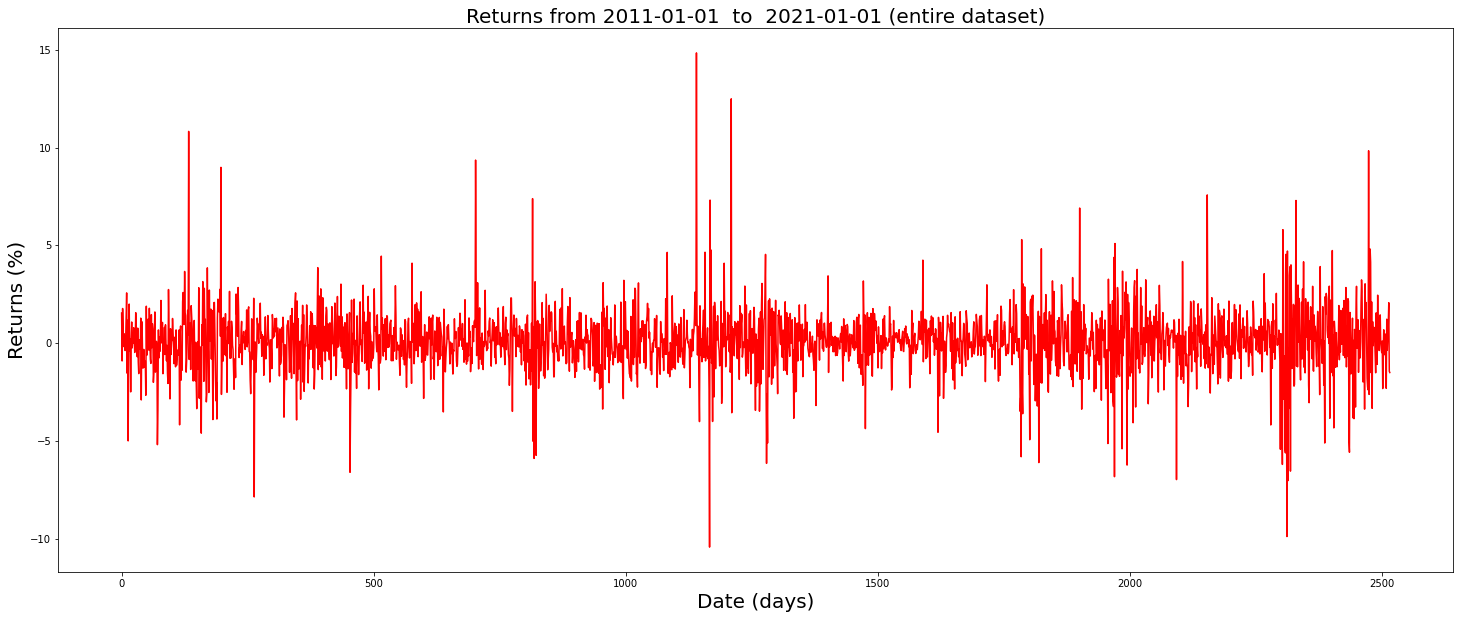

In [203]:
# Plot of returns dataset

plt.figure(figsize=(25,10))
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Returns (%)", fontsize = 20)
plt.title("Returns from 2011-01-01  to  2021-01-01 (entire dataset)", fontsize = 20)

plt.plot(range(len(returns)), returns*100, color="red") 

####**Utility functions**

In [204]:
def stand(x):
  
  mean = x.mean()
  std = x.std()
  x = (x-mean)/std
  return x, torch.tensor([mean, std])


def destand(x, stat):

  x = x*stat[1]+stat[0]
  return x

### **Splitting training and test set**

In [205]:
# Splitting datatset in training and test

train_returns, test_returns = train_test_split(returns, test_size =0.2, shuffle = False)    # splitting train-test 80-20. Shuffle false!

print("Size of training dataset: ", train_returns.shape,"\n",
      "\nSize of test dataset: ", test_returns.shape)

Size of training dataset:  torch.Size([2012]) 
 
Size of test dataset:  torch.Size([504])


In [206]:
# preparing dataset for up-down accuracy, to be confronted with random walk accuracy (50% the guess is right) 

train_signs, test_signs = torch.sign(train_returns), torch.sign(test_returns)

train_nsigns = torch.clamp(train_signs,min = 0) # this torch.clamp transformation will make it easy to calculate up-down accuracy from loss
test_nsigns = torch.clamp(test_signs,min = 0)

## **Hyperparameters**

In [595]:
print(torch.cuda.is_available())
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

False


In [750]:
epochs = 150
bs = 16
window = 30      # length of past sequence (days) given to model
pred_days = 1   # number of points (days) predicted by the model
lr = 0.001

num_inputs = 1 # number of features (channels) of time series. It is 1 for a univariate time series
num_channels = [5,5,5,1] # model has len(num_channels) conv1D layers, with number of output channels per layer defined by elements in num_channels
kernel_size = 5 # maximum receptive field is ( 2**(len(num_channels) -1) ) * (kernel_size-1) + 1

##**Preprocessing pt.2**

In [751]:
# Taking into account forecasting gap between training and test set:

ext_test_returns = torch.cat([train_returns[-window:], test_returns])

ext_test_signs = torch.cat([train_signs[-window:], test_signs]) 
ext_test_nsigns = torch.cat([train_nsigns[-window:], test_nsigns])

In [752]:
# Standardizing training and test dataset to mean = 0 and std = 1

tr_ret, tr_stat = stand(train_returns)
ext_te_ret, ext_te_stat = stand(ext_test_returns)

print("mean and std of train and test dataset:\n\n", tr_stat[0], tr_stat[1], "\t", ext_te_stat[0], ext_te_stat[1], 
      "\n\nmean and std of standardized train and test dataset:\n\n", tr_ret.mean(), tr_ret.std(),"\t", ext_te_ret.mean(), ext_te_ret.std())

mean and std of train and test dataset:

 tensor(0.0007) tensor(0.0155) 	 tensor(0.0011) tensor(0.0193) 

mean and std of standardized train and test dataset:

 tensor(3.7919e-09) tensor(1.) 	 tensor(4.4648e-09) tensor(1.)


###**Plot of standardized 'open prices' returns from training dataset**

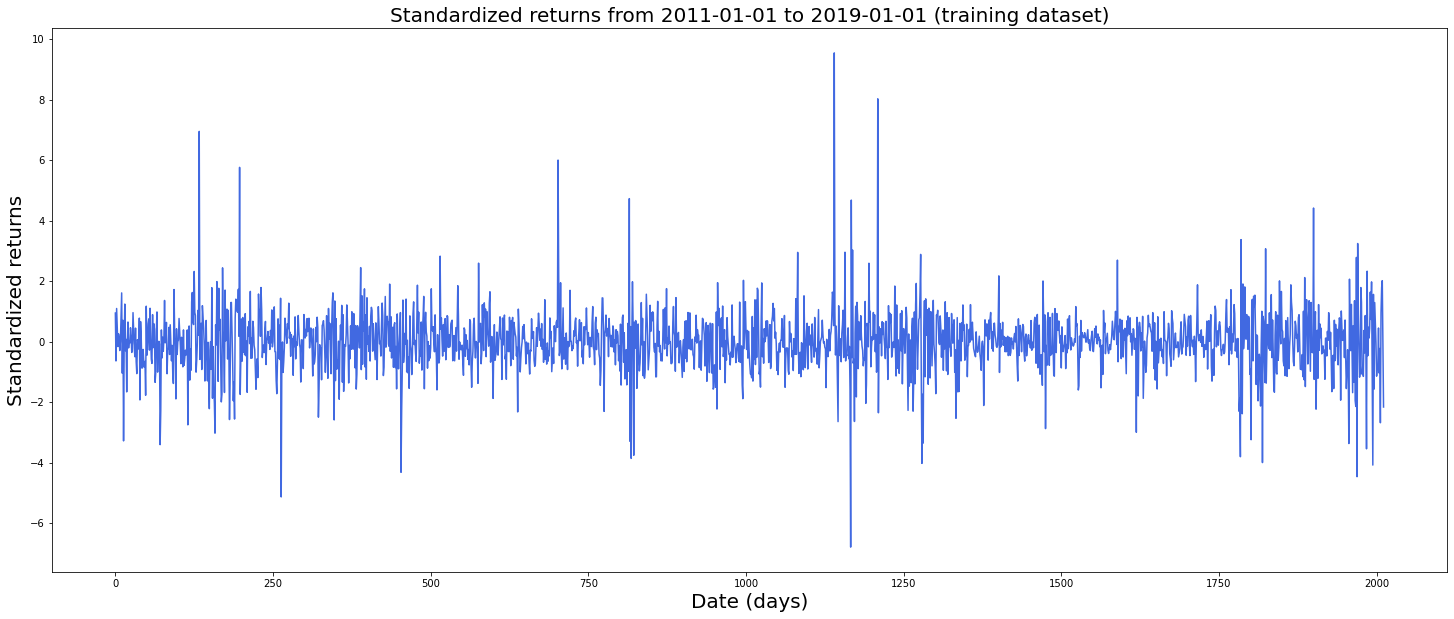

In [753]:
# Plot of standardized returns from training dataset

plt.figure(figsize=(25,10))
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Standardized returns", fontsize = 20)
plt.title("Standardized returns from 2011-01-01 to 2019-01-01 (training dataset)", fontsize = 20)

plt.plot(range(len(tr_ret)), tr_ret, color = "royalblue" )

###**Plot of signed 'open prices' returns from training dataset**

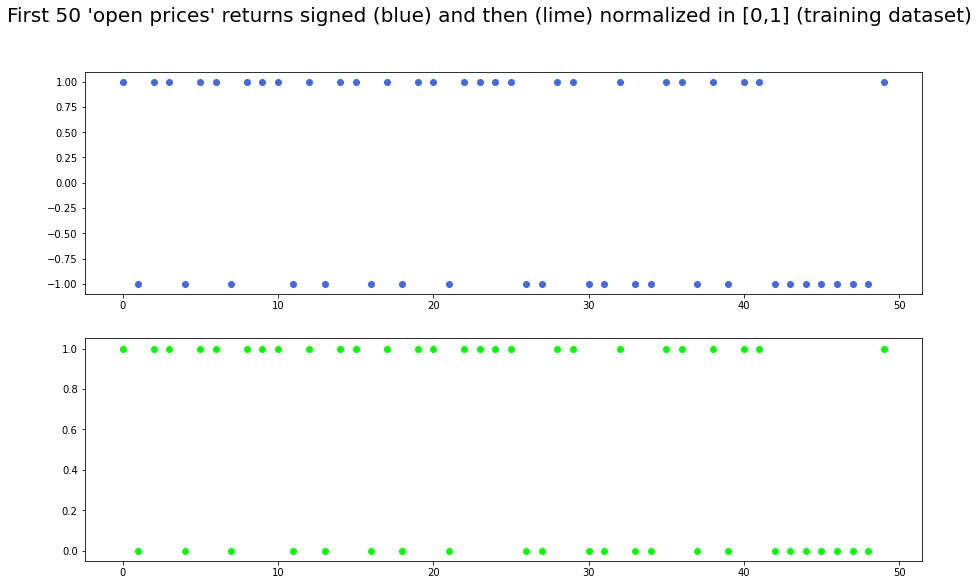

In [754]:
fig, axs = plt.subplots(2, figsize=(15,9))
plt.suptitle("First 50 'open prices' returns signed (blue) and then (lime) normalized in [0,1] (training dataset)", fontsize=20)

axs[0].scatter(range(len(tr_ret[:50])), train_signs[:50], color = "royalblue")#,
axs[1].scatter(range(len(tr_ret[:50])), train_nsigns[:50], color = "lime")#,

## **Creating dataset and dataloader for time series**

In [755]:
class Window_ds(Dataset):

  def __init__(self, data, window = 5):
    self.data = data
    self.window = window

  def __len__(self):
    return len(self.data) - self.window - pred_days 

  def __getitem__(self, idx):
    sample = self.data[idx: idx + self.window]
    target = self.data[idx+self.window:idx+self.window+ pred_days]

    return sample,target

In [756]:
test_ds = Window_ds(ext_te_ret, window = window)
test_dl = DataLoader(test_ds, batch_size=bs*2, shuffle=False)

##**TCN model**

In [757]:
class causalPad(nn.Module):

  def __init__(self, padding):

    super().__init__()

    self.padding = padding

  def forward(self,x):
    out = x[:,:,:-self.padding] # [batch, in_channels, in_length], excluding right padding
    return out


class TCN_layer(nn.Module):
  
  def __init__(self, in_channels, out_channels, kernel_size, dilation, padding, stride):

    super().__init__()

    
    self.conv = nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation))
    self.padding = causalPad(padding)
    self.dropout = nn.Dropout(0.2)
    self.tanh = nn.Tanh()
    self.network = nn.Sequential(self.conv, self.padding, self.dropout, self.tanh) # one TCN block

  def forward(self, x):  
    x = self.network(x) # [batch, out_channels, out_length]
    return x




class TCN(nn.Module):

  def __init__(self, num_inputs, num_channels, kernel_size = kernel_size):

    super().__init__()

    layers = []
    levels = len(num_channels)

    for i in range(levels):

      d = 2**i
      p = d*(kernel_size-1)

      if i == 0:
        in_channels = num_inputs
      else:
        in_channels = num_channels[i-1]
      out_channels = num_channels[i]
      
      layers += [TCN_layer(in_channels, out_channels, kernel_size, dilation = d, padding = p, stride = 1)] # creating TCN blocks, one for every dilation
    
    self.model = nn.Sequential(*layers)


  def forward(self, x):
   
    return self.model(x)

In [758]:
class temporal_CN(nn.Module):

  def __init__(self, num_inputs, num_channels, kernel_size, window, output):

    super().__init__()

    self.tcn = TCN(num_inputs, num_channels, kernel_size)
    self.linear = nn.Linear(window, output)

  def forward(self, x):

    x = self.tcn(x)
    out = self.linear(x).squeeze(1)
    return out

In [759]:
model = temporal_CN(num_inputs, num_channels, kernel_size, window, pred_days).to(dev)
print(model)

temporal_CN(
  (tcn): TCN(
    (model): Sequential(
      (0): TCN_layer(
        (conv): Conv1d(1, 5, kernel_size=(5,), stride=(1,), padding=(4,))
        (padding): causalPad()
        (dropout): Dropout(p=0.2, inplace=False)
        (tanh): Tanh()
        (network): Sequential(
          (0): Conv1d(1, 5, kernel_size=(5,), stride=(1,), padding=(4,))
          (1): causalPad()
          (2): Dropout(p=0.2, inplace=False)
          (3): Tanh()
        )
      )
      (1): TCN_layer(
        (conv): Conv1d(5, 5, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(2,))
        (padding): causalPad()
        (dropout): Dropout(p=0.2, inplace=False)
        (tanh): Tanh()
        (network): Sequential(
          (0): Conv1d(5, 5, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(2,))
          (1): causalPad()
          (2): Dropout(p=0.2, inplace=False)
          (3): Tanh()
        )
      )
      (2): TCN_layer(
        (conv): Conv1d(5, 5, kernel_size=(5,), stride=(1,), paddin

In [760]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

363

##**Choosing loss and optimizer**

In [761]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr = lr)

##**Training on standardized returns**

###**Time series cross validation**

In [762]:
n_split = 4

tsp = TimeSeriesSplit(n_split) 

train_stat_l = []
val_stat_l = []

train_loss_l = []
val_loss_l = []


for train_idx, val_idx in tsp.split(train_returns):

  train, t_stats = stand(train_returns[train_idx]) # training and validation set for every split are standardized according to their length and data, to ease training process
  ext_val_idx = np.append(train_idx[-window:],val_idx) # accounting for forecasting gap between training and validation set
  val, v_stats = stand(train_returns[ext_val_idx])
  train_stat_l.append(t_stats)
  val_stat_l.append(v_stats)

  train_ds = Window_ds(train, window = window)
  train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
  val_ds = Window_ds(val, window = window)
  val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)

  # Start learning
  model = temporal_CN(num_inputs,num_channels, kernel_size, window, pred_days).to(dev)

  opt = optim.Adam(model.parameters(),lr = lr)
  for epoch in range(epochs):

    model.train()  
    for s, t in train_dl:
      
      s, t = s.unsqueeze(1).to(dev) , t.to(dev)
      pred = model(s)
      tr_loss = loss_func(pred, t)

      tr_loss.backward()
      opt.step()
      opt.zero_grad()
    
    model.eval()
    with torch.no_grad():

      for s, t in val_dl:
      
        s, t = s.unsqueeze(1).to(dev) , t.to(dev)
        pred = model(s)
        v_loss = loss_func(pred, t)

    train_loss_l.append(tr_loss) 
    val_loss_l.append(v_loss) 

In [763]:
train_stat = torch.stack(train_stat_l,dim=0)
val_stat = torch.stack(val_stat_l,dim=0)
train_loss = torch.stack(train_loss_l,dim=0).reshape(n_split,-1).detach()
val_loss = torch.stack(val_loss_l,dim=0).reshape(n_split,-1).detach()

####**Plot of training and validation losses during cross validation**

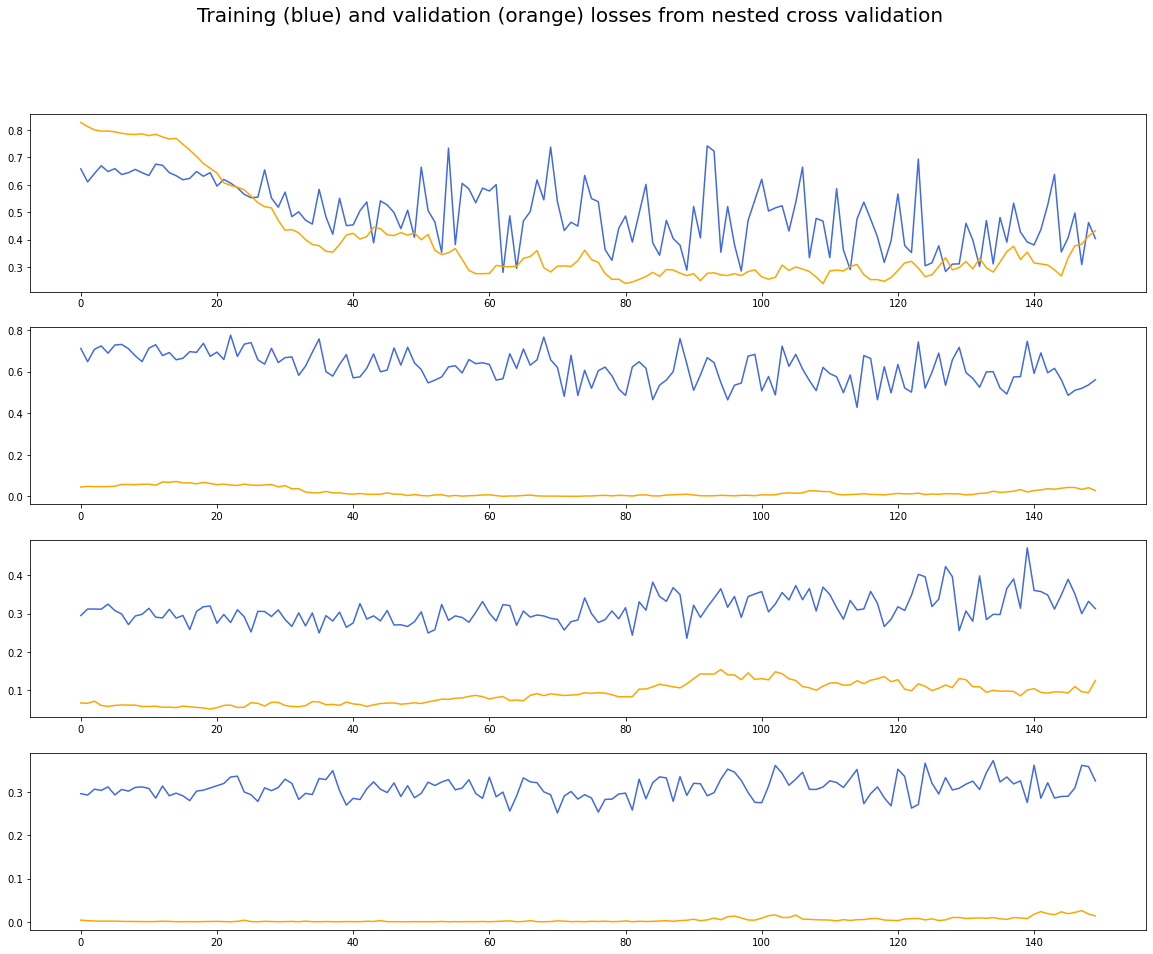

In [764]:
fig, axs = plt.subplots(n_split, figsize=(20,15))
plt.suptitle("Training (blue) and validation (orange) losses from nested cross validation", fontsize=20)

for i in range(n_split):

  axs[i].plot(range(epochs),train_loss[i], color = "royalblue")#,
  axs[i].plot(range(epochs),val_loss[i], color = "orange")#,

####**Plot of mean validation loss on training dataset**


Smaller validation loss is: 0.08232162147760391 at epoch 81 



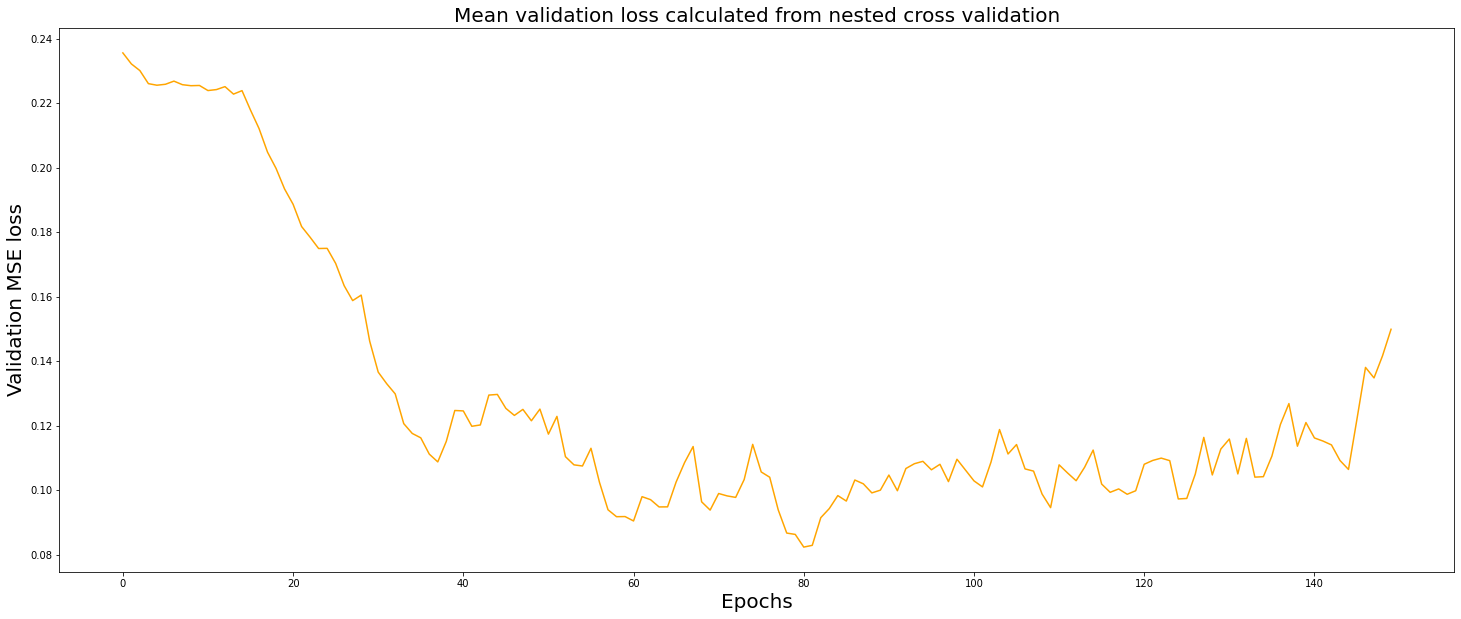

In [765]:
mean_val_loss = val_loss.mean(dim=0)

minimum = torch.min(mean_val_loss)
best_epoch = torch.argmin(mean_val_loss)
print("\nSmaller validation loss is:", minimum.item(),"at epoch", (best_epoch+1).item(),"\n")

plt.figure(figsize=(25,10))
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel("Validation MSE loss", fontsize = 20)
plt.title("Mean validation loss calculated from nested cross validation", fontsize = 20)
plt.plot(range(epochs), mean_val_loss, color = "orange")


In [766]:
train_ds = Window_ds(tr_ret, window = window)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)

samples, targets = next(iter(train_dl))

In [767]:
print("Training dataset length: ", len(train_ds),"\n", "\nShape of batch of samples: ", samples.shape,"\n", 
      "\nShape of batch of targets: ", targets.shape)

Training dataset length:  1981 
 
Shape of batch of samples:  torch.Size([16, 30]) 
 
Shape of batch of targets:  torch.Size([16, 1])


In [768]:
training_loss = []
test_loss = []

train_predictions = []
test_predictions = []

model = temporal_CN(num_inputs,num_channels, kernel_size, window, pred_days).to(dev)
opt = optim.Adam(model.parameters(), lr = lr)


for epoch in range(best_epoch+2): # "+ 2 as debug in case best epoch is 0"

  model.train()  
  for s, t in train_dl:

    s, t = s.unsqueeze(1).to(dev) , t.to(dev)
    pred = model(s)
    tr_loss = loss_func(pred, t)
    
    tr_loss.backward()
    opt.step()
    opt.zero_grad()

    if epoch == (best_epoch+1):
      pred = pred.reshape(-1)
      train_predictions.append(pred)

  training_loss.append(tr_loss)  
  
  model.eval()
  with torch.no_grad():
  
    for s, t in test_dl:
    
      s, t = s.unsqueeze(1).to(dev) , t.to(dev)   
      pred = model(s)
      te_loss = loss_func(pred, t)

      if epoch == best_epoch+1:
        pred = pred.reshape(-1)
        test_predictions.append(pred)

  test_loss.append(te_loss)  
train_predictions = torch.cat(train_predictions)#.cpu()
test_predictions = torch.cat(test_predictions)#.cpu()   

#### **Plot of training and test loss**

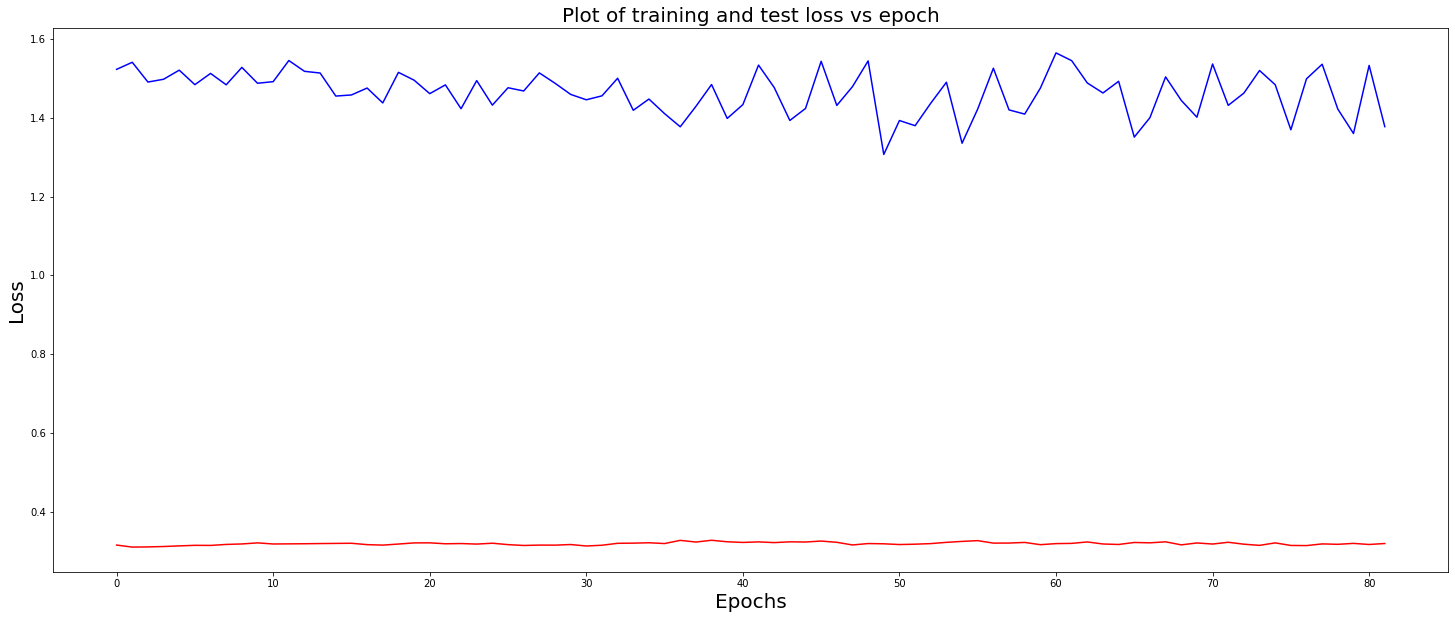

In [769]:
# Plot of training and test loss

plt.figure(figsize=(25,10))
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.title("Plot of training and test loss vs epoch", fontsize = 20)
plt.plot(range(len(training_loss)), training_loss, color = "blue")
plt.plot(range(len(test_loss)), test_loss, color = "red")


Loss value of last epoch:  tensor(0.3190)


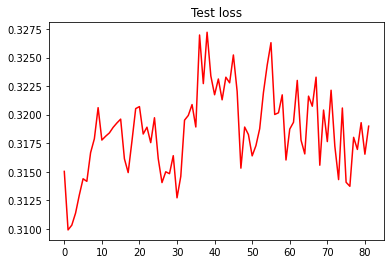

In [770]:
plt.plot(range(len(test_loss)), test_loss, color = "red")
plt.title("Test loss")
print("Loss value of last epoch: ",test_loss[-1])

In [771]:
#Calculating returns form standardized returns

tr_preds = destand(train_predictions, tr_stat).detach()
te_preds = destand(test_predictions, ext_te_stat).detach()

##**Testing on standardized test returns**

####**Plot of predicted and real returns for training dataset**

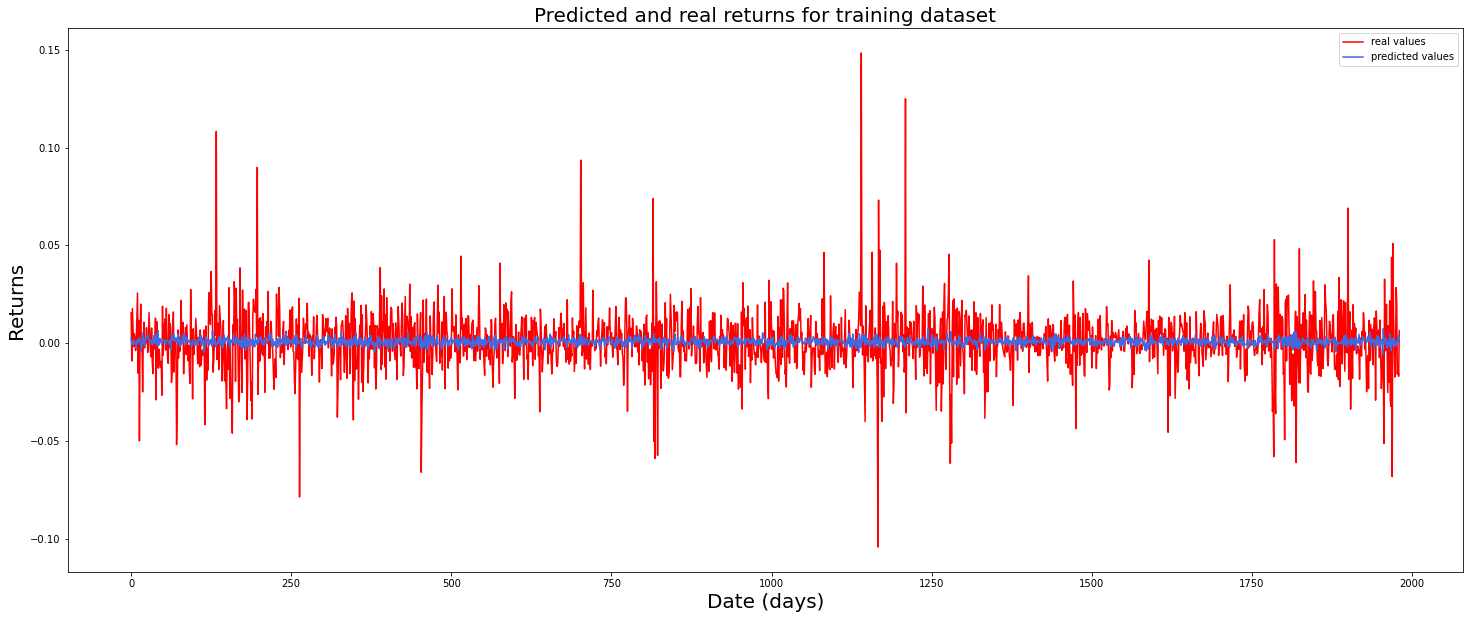

In [772]:
plt.figure(figsize=(25,10))
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Returns", fontsize = 20)
plt.title("Predicted and real returns for training dataset", fontsize = 20)

plt.plot(range(len(tr_preds)), returns[:len(tr_preds)], color="red")
plt.plot(range(len(tr_preds)), tr_preds, color = "royalblue")
plt.legend(["real values", "predicted values"])

##**Visualizing predictions**

###**Reconstructing 'open prices' training and test predictions**

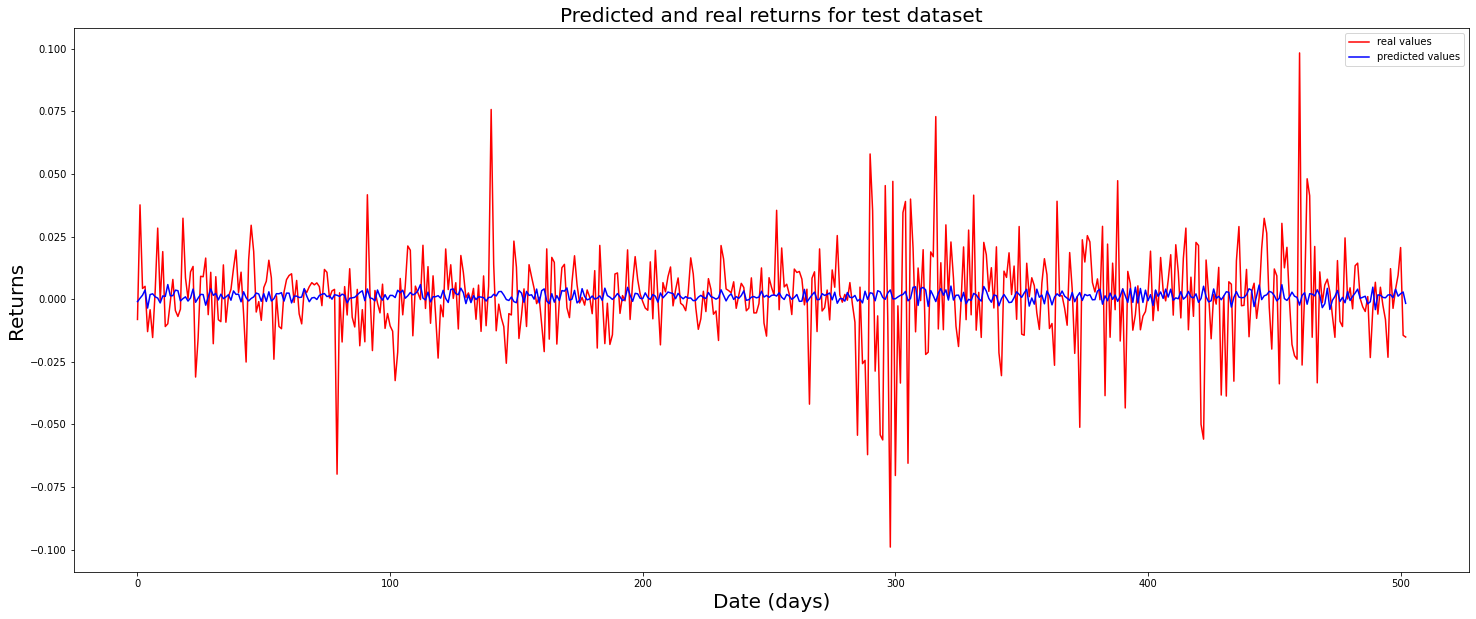

In [773]:
plt.figure(figsize=(25,10))
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Returns", fontsize = 20)
plt.title("Predicted and real returns for test dataset", fontsize = 20)
plt.plot(range(len(te_preds)), returns[-len(te_preds):], color = "red")
plt.plot(range(len(te_preds)), te_preds, color = "blue")
plt.legend(["real values", "predicted values"])

In [774]:
# Reconstructing predicted open prices on training dataset

first_price = data[0]
train_val = torch.zeros(len(tr_preds))
train_val[0] = first_price + tr_preds[0]*first_price# / 100

for i in range(len(tr_preds)-1):
  train_val[i+1] = train_val[i] + tr_preds[i]*train_val[i]# / 100

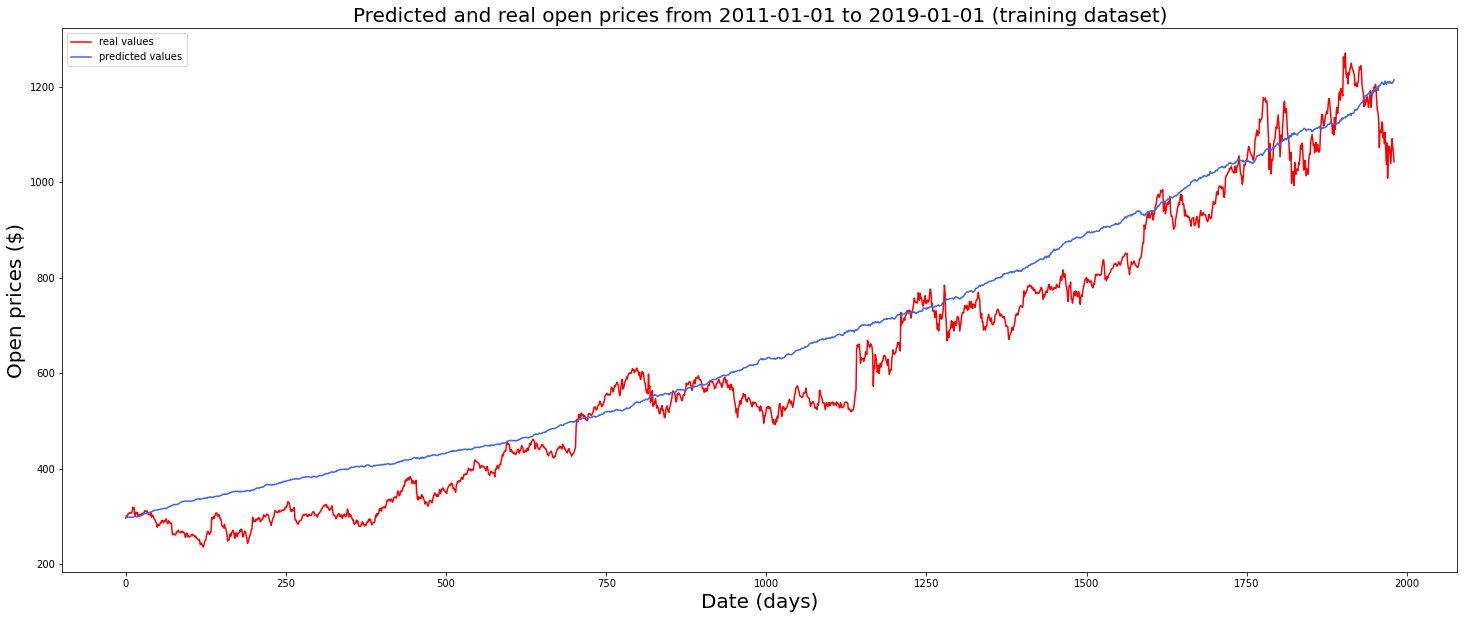

In [775]:
plt.figure(figsize=(25,10))
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Open prices ($)", fontsize = 20)
plt.title("Predicted and real open prices from 2011-01-01 to 2019-01-01 (training dataset)", fontsize = 20)
p = data[:len(train_val)]

plt.plot(range(len(p)), p, color = "red")
plt.plot(range(len(train_val)), train_val, color = "royalblue")
plt.legend(["real values", "predicted values"])

In [776]:
# Reconstructing predicted open prices on test dataset

first_price = data[len(train_returns)-1]
test_val = torch.zeros(len(te_preds))
test_val[0] = first_price + te_preds[0]*first_price

for i in range(len(te_preds)-1):

  test_val[i+1] = test_val[i] + te_preds[i]*test_val[i] 

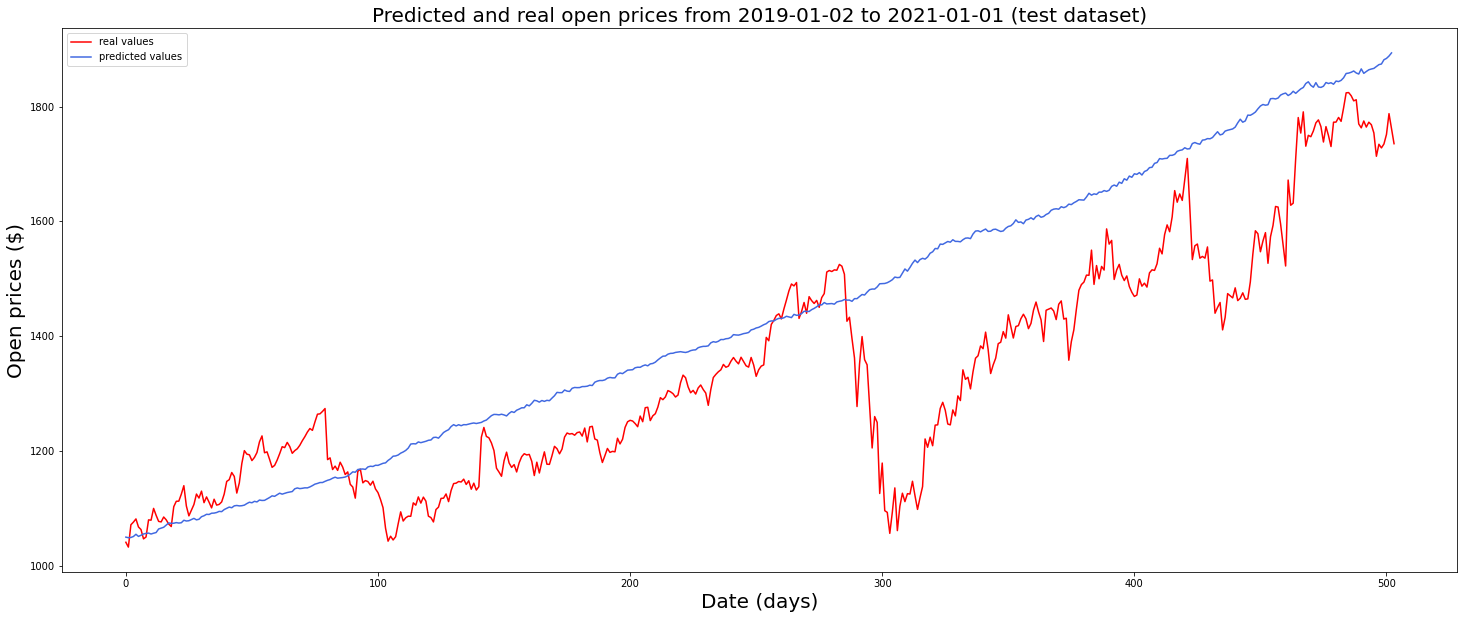

In [777]:
plt.figure(figsize=(25,10))
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Open prices ($)", fontsize = 20)
plt.title("Predicted and real open prices from 2019-01-02 to 2021-01-01 (test dataset)", fontsize = 20)
p = data[-len(test_returns):]
plt.plot(range(len(p)), p, color = "red")
plt.plot(range(len(test_val)), test_val, color = "royalblue" )
plt.legend(["real values", "predicted values"])

##**Persistence algorithm for naive forecast**

In [778]:
def naive_forecast(x):
  return x

In [779]:
naive_preds = []

for d in naive_data:
  forecast = naive_forecast(d)
  naive_preds.append(forecast.item())

naive_preds = torch.tensor(naive_preds)

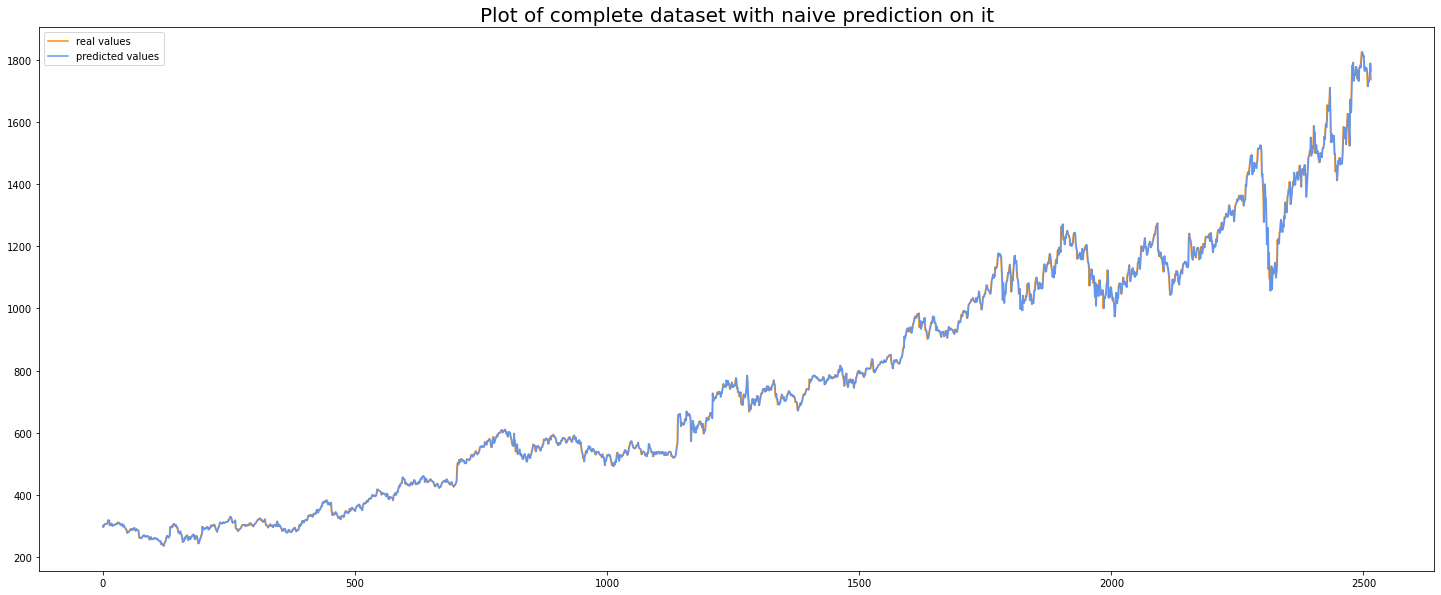

In [780]:
plt.figure(figsize=(25,10))
plt.title("Plot of complete dataset with naive prediction on it", fontsize = 20)
plt.plot(range(len(data)-1), data[1:], color = "darkorange")
plt.plot(range(len(naive_data)),naive_preds, color = "cornflowerblue")
plt.legend(["real values", "predicted values"])

##**Confronting final losses**

In [781]:
naive_loss = loss_func(naive_preds[:len(tr_ret)], data[1:len(tr_ret)+1])
final_test_loss = loss_func(train_val, data[:len(train_val)])

print("Training prediction loss: ", final_test_loss.item(), "\t", "Naive training loss: ", naive_loss.item())

naive_loss = loss_func(naive_preds[len(tr_ret):], data[len(tr_ret)+1:])
final_train_loss = loss_func(test_val, data[-len(test_val):])

print("Test prediction loss: ", final_train_loss.item(), "\t", "Naive test loss: ", naive_loss.item())

Training prediction loss:  5188.386370461107 	 Naive training loss:  114.4394676369445
Test prediction loss:  23587.96781013358 	 Naive test loss:  654.1159995044286


##**Testing on normalized signed returns**

In [782]:
test2_ds = Window_ds(ext_test_signs, window = window)
test2_dl = DataLoader(test2_ds, batch_size=bs*2, shuffle=False)

loss2_func = nn.MSELoss(reduction = "sum")

###**Calculating up-down loss and accuracy**

In [783]:
test2_loss = 0

model.eval()
with torch.no_grad():

  for s, t in test2_dl:
  
    s, t = s.unsqueeze(1).to(dev) , t.to(dev)    
    pred = model(s)
    pred = torch.sign(pred)
    pred, t = torch.clamp(pred, min = 0), torch.clamp(t, min = 0)
    te_loss = loss2_func(pred, t)
    test2_loss += te_loss

In [784]:
accuracy = test2_loss/len(ext_test_signs)*100
print(accuracy)

tensor(49.4382)
